# Create figure 2 : RSA on respiratory cycles

Here a short demo that generate the figure2

In [85]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import physio

In [87]:
plt.rcParams.update({
    'font.size': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,

})



In [88]:
data_folder = Path('/home/samuel/Documents/physio_benchmark/data')

data_file = data_folder / 'human' / 'S00.txt'

# Open and explore data

In [89]:
data = np.loadtxt(data_file)
data.shape
raw_ecg = data[:, 0]
raw_resp = data[:, 1]

srate = 1000
times = np.arange(raw_ecg.size) / srate


(100.0, 150.0)

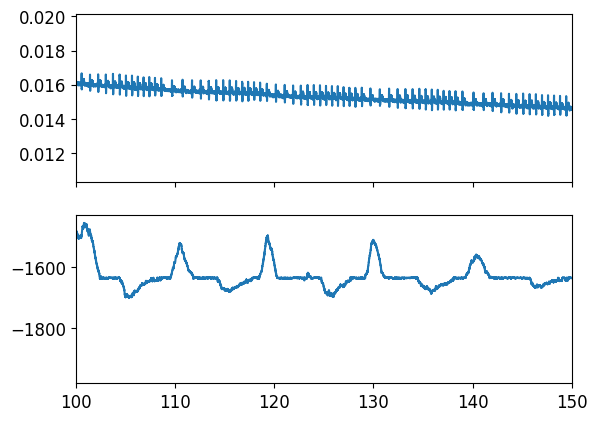

In [90]:
fig, axs = plt.subplots(sharex=True, nrows=2)
ax = axs[0]
ax.plot(times, raw_ecg)

ax = axs[1]
ax.plot(times, raw_resp)

ax.set_xlim(100, 150)

# compute ecg rpeak, resp cycle and rsa

In [91]:
ecg, ecg_peaks = physio.compute_ecg(raw_ecg, srate, parameter_preset='human_ecg')

In [92]:

resp, resp_cycles = physio.compute_respiration(raw_resp, srate, parameter_preset='human_airflow')


In [93]:
rate_times = np.arange(0,  times[-1] + 1/50., 1/50.) # 50Hz
instantaneous_cardiac_rate = physio.compute_instantaneous_rate(ecg_peaks, rate_times,
                                                               limits=None, units='bpm', interpolation_kind='linear')

In [94]:
points_per_cycle = 100
one_cycle = np.arange(points_per_cycle) / points_per_cycle

In [95]:
# one segment cyclic cardiac rate
cycle_times = resp_cycles[['inspi_time', 'next_inspi_time']].values

cyclic_cardiac_rate_1seg = physio.deform_traces_to_cycle_template(instantaneous_cardiac_rate, rate_times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=None)


In [96]:
# two segments respiratory cycle strech
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))
segment_ratios = [inspi_ratio]

cyclic_resp_2seg = physio.deform_traces_to_cycle_template(resp, times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

In [97]:
# two segments cyclic cardiac rate
cycle_times = resp_cycles[['inspi_time', 'expi_time','next_inspi_time']].values
inspi_ratio = np.mean((cycle_times[:, 1] - cycle_times[:, 0]) / (cycle_times[:, 2] - cycle_times[:, 0]))

segment_ratios = [inspi_ratio]

cyclic_cardiac_rate_2seg = physio.deform_traces_to_cycle_template(instantaneous_cardiac_rate, rate_times, cycle_times,
                                                points_per_cycle=points_per_cycle, segment_ratios=segment_ratios)

In [98]:
inspi_ratio

0.38074235319496336

# make figure

In [99]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

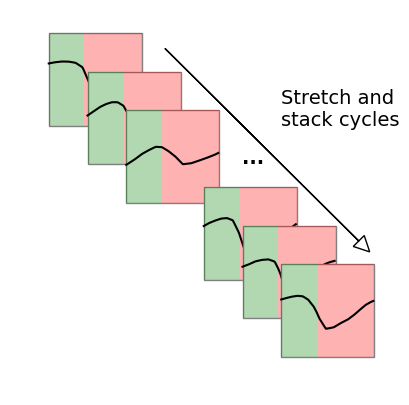

In [100]:
# this function create the panel (D)
def sketch_stack_cycles(ax):

    for k in ('top', 'right', 'left', 'bottom'):
        ax.spines[k].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    w = 120.
    rectangles = []
    for i in range(7):
        if i in (3, ):
            continue

        z = (i + 1) * 10
        x = 100 + i * 50
        y = 400 - i * 50
        rect = plt.Rectangle((x, y), w, w, ec='gray', fc='w', zorder=z+1)
        ax.add_patch(rect)
        rect = plt.Rectangle((x, y), w*inspi_ratio, w, ec=None, fc='g', alpha=0.3, zorder=z+2)
        ax.add_patch(rect)
        rect = plt.Rectangle((x + w * inspi_ratio, y), w * (1 - inspi_ratio), w,  ec=None, fc='r', alpha=0.3, zorder=z+3)
        ax.add_patch(rect)

        cycle_phase = np.arange(points_per_cycle) / points_per_cycle
        cycle_value = cyclic_cardiac_rate_2seg[i, :]

        ax.plot(cycle_phase * w + x, cycle_value + y + w /2 - np.mean(cycle_value), color='black', zorder=z + 5)

    ax.arrow(250, 500, 250, -250, head_width=20, head_length=20, fc='w', ec='k')
    ax.text(350, 350, "...", weight='bold',)
    ax.text(400, 400, "Stretch and\nstack cycles")

    ax.set_xlim(50, 550)
    ax.set_ylim(50, 550)
fig, ax = plt.subplots(figsize=(5, 5))
sketch_stack_cycles(ax)


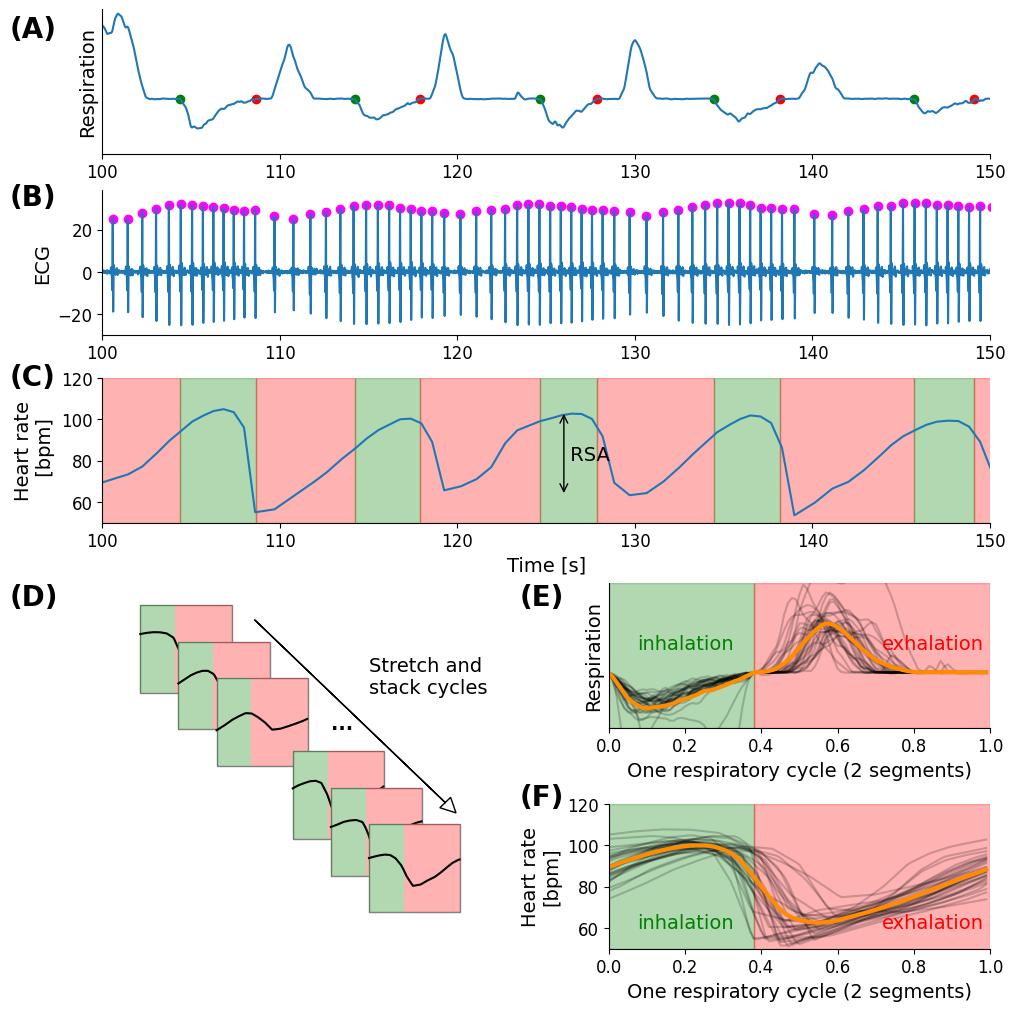

In [101]:
fig = plt.figure(layout="constrained", figsize=(10, 10))
gs = plt.GridSpec(nrows=5, ncols=4, figure=fig)

ax = ax_A = fig.add_subplot(gs[0, :])
simpleaxis(ax)
ax.set_ylabel('Respiration')
ax.plot(times, resp)
inspi_index = resp_cycles['inspi_index'].values
expi_index = resp_cycles['expi_index'].values
ax.scatter(times[inspi_index], resp[inspi_index], marker='o', color='green')
ax.scatter(times[expi_index], resp[expi_index], marker='o', color='red')
ax.set_yticks([])
ax.set_ylim(-1750, -1450)

ax = ax_B = fig.add_subplot(gs[1, :],  sharex=ax)
ax.set_ylabel('ECG')
simpleaxis(ax)
ax.plot(times, ecg)
ecg_peak_ind = ecg_peaks['peak_index'].values
ax.scatter(times[ecg_peak_ind], ecg[ecg_peak_ind], marker='o', color='magenta')

ax = ax_C = fig.add_subplot(gs[2, :], sharex=ax)
ax.set_ylabel('Heart rate\n [bpm]')
simpleaxis(ax)
ax.plot(rate_times, instantaneous_cardiac_rate)
for c, cycle in resp_cycles.iterrows():
    ax.axvspan(cycle['inspi_time'], cycle['expi_time'], color='g', alpha=0.3)
    ax.axvspan(cycle['expi_time'], cycle['next_inspi_time'], color='r', alpha=0.3)
ax.set_ylim(50, 120)
ax.set_xlim(100, 150)
ax.annotate(text='', xy=(126,104), xytext=(126, 63), arrowprops=dict(arrowstyle='<->'))
ax.text(126, 80, ' RSA', ha='left')
ax.set_xlabel('Time [s]')


ax = ax_D = fig.add_subplot(gs[3:, :2])
sketch_stack_cycles(ax)


ax = ax_E = fig.add_subplot(gs[3, 2:])
simpleaxis(ax)
ax.plot(one_cycle, cyclic_resp_2seg.T, color='k', alpha=0.2)
ax.plot(one_cycle, np.mean(cyclic_resp_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylabel('Respiration')
ax.text(0.2, -1600, 'inhalation', ha='center', color='g')
ax.text(0.85, -1600, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_ylim(-1720, -1500)


ax = ax_F = fig.add_subplot(gs[4, 2:])
simpleaxis(ax)
ax.plot(one_cycle, cyclic_cardiac_rate_2seg.T, color='k', alpha=0.2)
ax.plot(one_cycle, np.mean(cyclic_cardiac_rate_2seg, axis=0), color='darkorange', lw=3)
ax.axvspan(0, inspi_ratio, color='g', alpha=0.3)
ax.axvspan(inspi_ratio, 1, color='r', alpha=0.3)
ax.set_ylim(50, 120)
ax.set_ylabel('Heart rate\n[bpm]')
ax.text(0.2, 60, 'inhalation', ha='center', color='g')
ax.text(0.85, 60, 'exhalation', ha='center', color='r')
ax.set_xlabel('One respiratory cycle (2 segments)')
ax.set_xlim(0, 1)


fig.text(0.0, 0.99, '(A)', weight='bold', fontsize=20, va='top')
fig.text(0.0, 0.80, '(B)', weight='bold', fontsize=20)
fig.text(0.0, 0.62, '(C)', weight='bold', fontsize=20)
fig.text(0.0, 0.40, '(D)', weight='bold', fontsize=20)
fig.text(0.51, 0.40, '(E)', weight='bold', fontsize=20)
fig.text(0.51, 0.20, '(F)', weight='bold', fontsize=20)

fig.savefig('figure2.png')
